In [2]:
import os
import cv2
from face_tracking import data_collection, process_unknown_celeb_faces, process_unknown_digiface_faces
import matplotlib.pyplot as plt
import shutil
from helpers import do_data_preprocessing, get_max_image_index_for_known_images
from constants import CELEB_ORIG_PATH, UNKNOWN_FACES_PATH, KNOWN_FACE_PATH, TESTING_PATH_POSITIVE, TESTING_PATH_NEGATIVE, VALIDATION_PATH_POSITIVE, VALIDATION_PATH_NEGATIVE, MODEL_INPUT_IMAGE_DIMENSIONS, DIGIFACE_ORIG_PATH
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## NOTE: AFTER DOING DATA PREPROCESSING, YOU NEED TO QUIT OUT OF THE JUPITER NOTEBOOK, OR ELSE IT WILL KEEP USING MEMORY IN THE BACKGROUND ##

#### Set paths Global Variables and get Face Detector

In [3]:
MAX_NUM_IMAGES = 10000 

if MAX_NUM_IMAGES > 10000:
    raise ValueError('MAX_NUM_IMAGES must be less than or equal to 10000 since there is only 200000 celebrity images')

PERCENT_TRAINING = 80
PERCENT_VALIDATION = 20
NUM_AUGMENTATIONS_PER_IMAGE = 10

Face_Detector = cv2.dnn.readNetFromCaffe("do_not_delete/deploy.prototxt.txt",
                                             "do_not_delete/res10_300x300_ssd_iter_140000.caffemodel")

#### ONLY RUN IF YOU WANT TO REPROCESS ALL FACES

In [ ]:
print("Deleting old files...")
for file in os.listdir(UNKNOWN_FACES_PATH):
    file_path = os.path.join(UNKNOWN_FACES_PATH, file)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
print("Done deleting files")
print("Loading digiface faces...")
process_unknown_digiface_faces(input_path=DIGIFACE_ORIG_PATH, output_path=UNKNOWN_FACES_PATH, face_detector=Face_Detector, num_augmentations_per_image=NUM_AUGMENTATIONS_PER_IMAGE)
print("Done loading digiface faces")
print("Loading celebrity faces...")
process_unknown_celeb_faces(input_path=CELEB_ORIG_PATH, output_path=UNKNOWN_FACES_PATH, face_detector=Face_Detector, num_augmentations_per_image=NUM_AUGMENTATIONS_PER_IMAGE)
print("Done loading celebrity faces")

Deleting old files...
Done deleting files
Loading digiface faces...
Processing 144072 photos...
5362/144072 [=>----------------------------] - ETA: 41:03

#### ONLY RUN IF YOU WANT TO RETAKE NEW PHOTOS

In [10]:
for file in os.listdir(KNOWN_FACE_PATH):
    file_path = os.path.join(KNOWN_FACE_PATH, file)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

"\nfor file in os.listdir(KNOWN_FACE_PATH):\n    file_path = os.path.join(KNOWN_FACE_PATH, file)\n    try:\n        if os.path.isfile(file_path) or os.path.islink(file_path):\n            os.unlink(file_path)\n        elif os.path.isdir(file_path):\n            shutil.rmtree(file_path)\n    except Exception as e:\n        print('Failed to delete %s. Reason: %s' % (file_path, e))\n"

#### Capture, crop, and process images of target face

In [6]:
if len(os.listdir(KNOWN_FACE_PATH)) >= MAX_NUM_IMAGES:
    print("Found files in directory already. To rerun, please empty " + KNOWN_FACE_PATH + " by running the code above ^^^")
else:
    data_collection(KNOWN_FACE_PATH, MAX_NUM_IMAGES-len(os.listdir(KNOWN_FACE_PATH)), starting_index=get_max_image_index_for_known_images(KNOWN_FACE_PATH) + 1)

Found files in directory already. To rerun, please empty data/faces/stephen by running the code above ^^^


#### Delete old files

In [3]:
for directory in os.listdir(os.path.join('data', 'data')):
    if os.path.isdir(os.path.join('data', 'data', directory)):
        for subdir in os.listdir(os.path.join('data', 'data', directory)):
            if os.path.isdir(os.path.join('data', 'data', directory, subdir)):
                for file in os.listdir(os.path.join('data', 'data', directory, subdir)):
                    file_path = os.path.join('data', 'data', directory, subdir, file)
                    try:
                        if os.path.isfile(file_path) or os.path.islink(file_path):
                            os.unlink(file_path)
                        elif os.path.isdir(file_path):
                            shutil.rmtree(file_path)
                    except Exception as e:
                        print('Failed to delete %s. Reason: %s' % (file_path, e))

#### Augment data and move to correct directories

In [4]:
if len(os.listdir(TESTING_PATH_POSITIVE)) > 0 or len(os.listdir(TESTING_PATH_NEGATIVE)) > 0 or len(os.listdir(VALIDATION_PATH_POSITIVE)) > 0 or len(os.listdir(VALIDATION_PATH_NEGATIVE)) > 0:
    print("Found files in directory already. To rerun, please empty " + TESTING_PATH_POSITIVE + ", " + TESTING_PATH_NEGATIVE + ", " + VALIDATION_PATH_POSITIVE + ", and " + VALIDATION_PATH_NEGATIVE + " by running the code above ^^^")
else:
    do_data_preprocessing(num_images=min(len(os.listdir(KNOWN_FACE_PATH)), MAX_NUM_IMAGES), input_dimensions=MODEL_INPUT_IMAGE_DIMENSIONS, known_face_path=KNOWN_FACE_PATH, unknown_face_path=UNKNOWN_FACES_PATH, percent_training=PERCENT_TRAINING, percent_validation=PERCENT_VALIDATION, testing_path_positive=TESTING_PATH_POSITIVE, testing_path_negative=TESTING_PATH_NEGATIVE, validation_path_positive=VALIDATION_PATH_POSITIVE, validation_path_negative=VALIDATION_PATH_NEGATIVE)

Processing 10000 known faces...
10000/10000 [==============================] - ETA: 0:00
Done!
Processing 100000 unknown faces...
100000/100000 [==============================] - ETA: 0:00
Done!


## Check Data

#### Run this once

In [9]:
datagen = ImageDataGenerator()
train_generator = datagen.flow_from_directory(
    os.path.join('data', 'data', 'testing'),
    target_size=MODEL_INPUT_IMAGE_DIMENSIONS,
    class_mode='binary'  # Automatically inferred based on the subdirectories
)
val_generator = datagen.flow_from_directory(
    os.path.join('data', 'data', 'validation'),
    target_size=MODEL_INPUT_IMAGE_DIMENSIONS,
    class_mode='binary',  # Use 'binary' for binary classification or 'categorical' for multiclass
)
print("Number of positive testing images: " + str(len(os.listdir(TESTING_PATH_POSITIVE))))
print("Number of negative testing images: " + str(len(os.listdir(TESTING_PATH_NEGATIVE))))
print("Number of positive validation images: " + str(len(os.listdir(VALIDATION_PATH_POSITIVE))))
print("Number of negative validation images: " + str(len(os.listdir(VALIDATION_PATH_NEGATIVE))))
t = iter(train_generator)
v = iter(val_generator)

Found 604484 images belonging to 2 classes.
Found 150868 images belonging to 2 classes.
Number of positive testing images: 248000
Number of negative testing images: 356484
Number of positive validation images: 62000
Number of negative validation images: 88868


#### To check data, you can rerun the following two code segments. It will show you each image with dimensions 

In [11]:
(x, y) = next(v) # change to "t" or "v" to check testing or validation data respectively
im = iter(x)
out = iter(y)

1.0
(100, 100, 3)


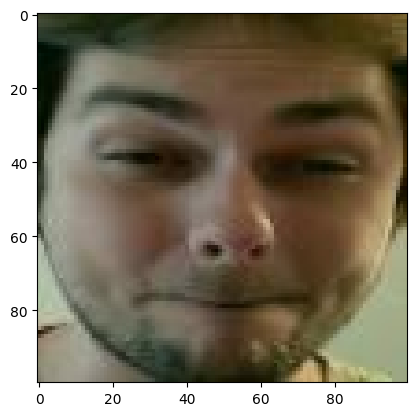

In [33]:
print(next(out))
image = next(im).astype(int)
print(image.shape)
plt.imshow(image)